# Use-Cases of TDA Usage on 3D Shapes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings, tqdm

warnings.simplefilter('ignore')
from filtration.filtration import *

pyo.init_notebook_mode(connected=True)
from mpl_toolkits.mplot3d import Axes3D

### Load the 3D cloud point

In [2]:
def load_3D_shape(filepath):

    vec = []
    num = sum(1 for line in open(filepath, 'r'))

    with open(filepath, 'r') as raw:
        for idx in tqdm.tqdm(range(num)):
            tmp = raw.readline().split(' ')
            if len(tmp) == 3: vec.append(np.asarray(tmp).astype('float'))

    vec = np.vstack(vec)
    
    return vec

vec = load_3D_shape('./samples/hand.off')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21722/21722 [00:00<00:00, 1056834.80it/s]


### Build the persistence, and extract the components of dimension 0

In [3]:
flt = Filtration(vec, use_alpha=False)
flt.persistence(type_filtration='simple', dimension=0)

### Compute the relative betti curve, based on dimension 0 components

In [4]:
btc = flt.betti_curve()

### Compute the relative landscapes, based on dimension 0 components

In [5]:
ldc = flt.landscapes()

### General visualization

In [6]:
# Recast persistence diagram for gudhi visualization tools
dig = [(0, tuple(e)) for e in flt.fil]

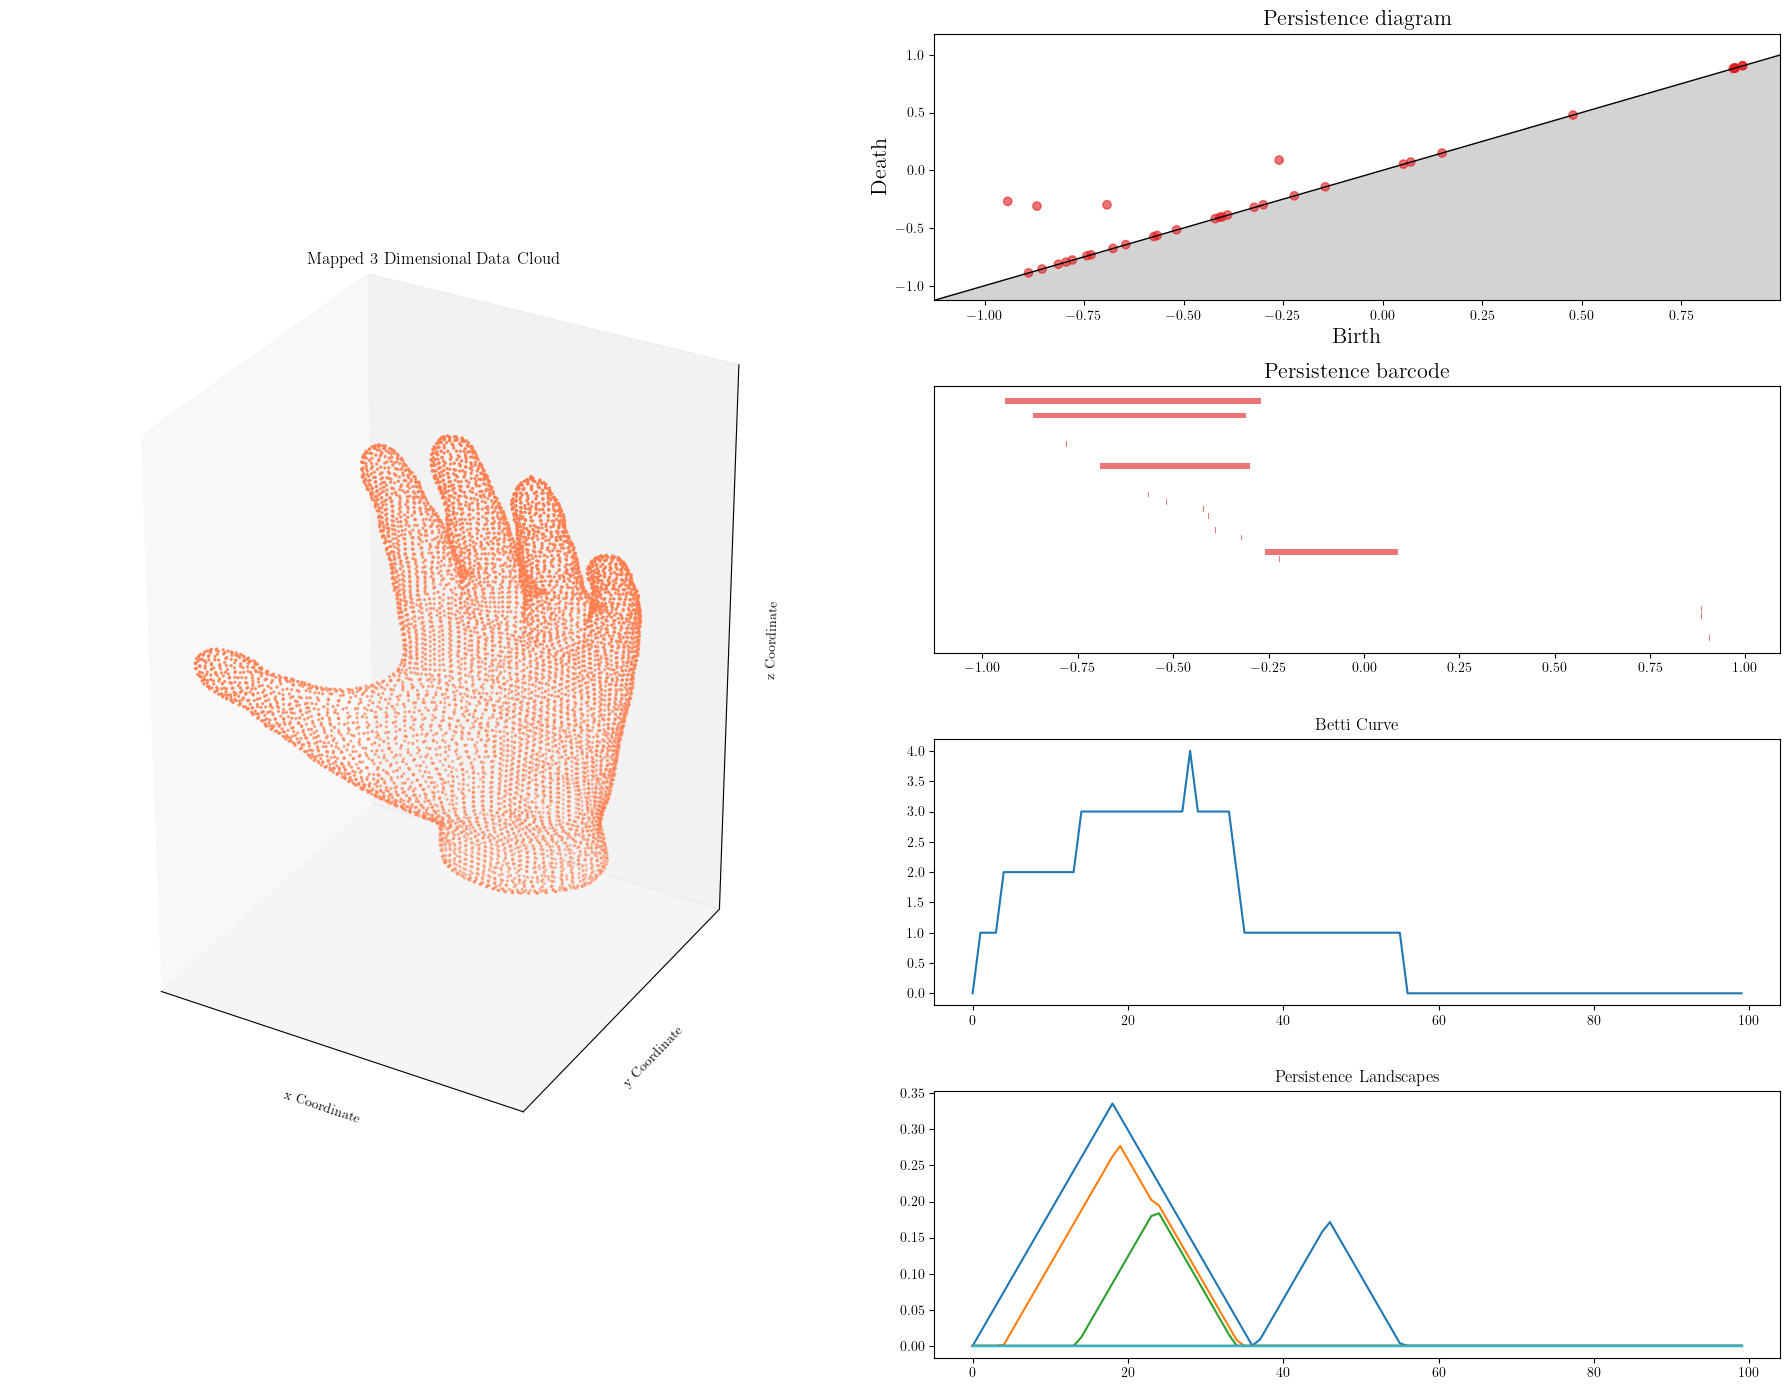

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
ax0 = fig.add_subplot(gs[0:, 0], projection='3d')
ax0.set_box_aspect(aspect = (1,1,1.5))
ax0.set_title('Mapped 3 Dimensional Data Cloud')
ax0.set_xticks([])                               
ax0.set_yticks([])                               
ax0.set_zticks([])
ax0.scatter(vec[:,0], vec[:,1], vec[:,2], s=2, c='coral')
ax0.set_xlabel('x Coordinate')
ax0.set_ylabel('y Coordinate')
ax0.set_zlabel('z Coordinate')
gudhi.plot_persistence_diagram(dig, axes = axs[0, 1])
gudhi.plot_persistence_barcode(dig, axes = axs[1, 1])
axs[2, 1].set_title('Betti Curve')
axs[2, 1].plot(btc)
axs[3, 1].set_title('Persistence Landscapes')
for ele in ldc: axs[3, 1].plot(ele)
fig.tight_layout()
plt.show()